# Project 3

Subject: Deep Learning

Date: 2023-04-07

Authors: Harshvardhan, Yu Jiang

# Introduction 

In this project, we use a modified version of the FairFace dataset to build five neural networks in order to classify three attributes: race, gender and age. All images are converted to gray scale and resized them to 32 × 32 to decrease the training time.

In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
import os
import time
import random

In [75]:
# import Keras layers
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import BatchNormalization

# Task 0: Load Images

### Functions for one-hot-encoding Age, Gender and Ethnicity

In [76]:
def convert_age(age):
    age_dict = {'0-2': 0, '3-9': 1, '10-19': 2, '20-29': 3, '30-39': 4, '40-49': 5, '50-59': 6, '60-69': 7, 'more than 70': 8}
    return np.eye(9)[[age_dict[a] for a in age]]

def convert_gender(gender):
    gender_dict = {'Male': 0, 'Female': 1}
    return np.eye(2)[[gender_dict[g] for g in gender]]

def convert_race(race):
    race_dict = {'Black': 0, 'Latino_Hispanic': 1, 'East Asian': 2, 'White': 3, 'Southeast Asian': 4, 'Middle Eastern': 5, 'Indian': 6}
    return np.eye(7)[[race_dict[r] for r in race]]

### Reading in images in parallel

In [77]:
# function to read image
def read_image(image_path):
    with Image.open(image_path) as image:
        return np.asarray(image)

# function to read image
def read_image(image_path):
    with Image.open(image_path) as image:
        return np.asarray(image)

# read data, labels in lists
def get_dataset(DATA_DIR, mode, sample=False):
    if mode == 'train':
        df = pd.read_csv(os.path.join(DATA_DIR, 'fairface_label_train.csv'))
    elif mode == 'val':
        df = pd.read_csv(os.path.join(DATA_DIR, 'fairface_label_val.csv'))
    else:
        raise ValueError

    age = df['age'].values.tolist()
    gender = df['gender'].values.tolist()
    race = df['race'].values.tolist()
    filenames = df['file'].values.tolist()

    image_paths = [os.path.join(DATA_DIR, name) for name in filenames]

    if sample:
        sample_size = int(len(image_paths) * 0.05) # 5% of total images
        sampled_indexes = random.sample(range(len(image_paths)), sample_size)
        image_paths = [image_paths[i] for i in sampled_indexes]
        age = [age[i] for i in sampled_indexes]
        gender = [gender[i] for i in sampled_indexes]
        race = [race[i] for i in sampled_indexes]

    with ThreadPoolExecutor() as executor:
        all_img = list(executor.map(read_image, image_paths))
    
    onehot_age = convert_age(age)
    onehot_gender = convert_gender(gender)
    onehot_race = convert_race(race)

    return all_img, onehot_age, onehot_gender, onehot_race

In [78]:
DATA_DIR = '/Users/harshvardhan/Library/CloudStorage/Dropbox/Academics/UTK Classes/Spring 2023/Deep Learning/Project 3/project3_COSC525'

In [80]:
train_img, train_age, train_gender, train_race = get_dataset(DATA_DIR,'train')
val_img, val_age, val_gender, val_race = get_dataset(DATA_DIR,'val')

In [ ]:
# Normalize the data with MinMaxScaler
flattened_train_img = [img.reshape(32*32) for img in train_img]
flattened_val_img = [img.reshape(32*32) for img in val_img]

scaler = MinMaxScaler()
scaler.fit(flattened_train_img)
print(len(scaler.data_max_), len(scaler.data_min_))

scaled_train_img = scaler.transform(flattened_train_img)
scaled_val_img = scaler.transform(flattened_val_img)

1024 1024


# Task 1: Fully Connected Neural Network

1. Build a feed forward neural network with the following specifications (Test on two different tasks):
- Hidden layer 1: 1024 neurons with hyperbolic tangent activation function in each
neuron.
- Hidden layer 2: 512 neurons, with sigmoid activation function in each of the
neuron.
- 100 neurons, with rectified linear activation function in each of the neuron.
- Output layer: n (depending on the task) neurons representing the n classes, using
the softmax activation function.


2. Using Min-Max scaling to scale the training dataset and using the same Min and Max values from the training set scale the test dataset $$x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$$.

3. sing mini-batch gradient descent to optimize the loss function: “categorical cross-entropy” on the training dataset. Please record the loss value for each of the epochs and create an epoch-loss plot and an accuracy-loss plot for both the training and validation set.

4. Report the following:
    - Final classification accuracy.
    - $n$-class confusion matrix.

In [ ]:
# Building the model
def get_model(output_dim):
    model = Sequential()
    model.add(Dense(1024, input_dim=32*32, activation='tanh'))
    model.add(Dense(512, activation='sigmoid'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    return model


## Classifying Gender

In [ ]:
lr = 0.001
opt = keras.optimizers.Adam(learning_rate=lr)
bs = 32
epochs = 50

In [ ]:
gender_model = get_model(2)
gender_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
train_history = gender_model.fit(scaled_train_img, np.array(train_gender),
                    batch_size=32, epochs=10,
                    verbose=1, shuffle=True, validation_data=(scaled_val_img, np.array(val_gender)))
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

2023-04-07 12:56:48.047986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
2711/2711 [==============================] - 20s 7ms/step - loss: 0.6211 - accuracy: 0.6470 - val_loss: 0.5699 - val_accuracy: 0.6874
Epoch 2/10
2711/2711 [==============================] - 20s 7ms/step - loss: 0.5822 - accuracy: 0.6805 - val_loss: 0.6024 - val_accuracy: 0.6387
Epoch 3/10
2711/2711 [==============================] - 20s 7ms/step - loss: 0.5659 - accuracy: 0.6908 - val_loss: 0.5523 - val_accuracy: 0.7060
Epoch 4/10
2711/2711 [==============================] - 19s 7ms/step - loss: 0.5583 - accuracy: 0.6961 - val_loss: 0.5376 - val_accuracy: 0.7129
Epoch 5/10
2711/2711 [==============================] - 19s 7ms/step - loss: 0.5529 - accuracy: 0.7027 - val_loss: 0.5558 - val_accuracy: 0.6955
Epoch 6/10
2711/2711 [==============================] - 19s 7ms/step - loss: 0.5496 - accuracy: 0.7032 - val_loss: 0.5370 - val_accuracy: 0.7087
Epoch 7/10
2711/2711 [==============================] - 19s 7ms/step - loss: 0.5459 - accuracy: 0.7067 - val_loss: 0.5537 - val_ac

#### Model Architecture

In [ ]:
gender_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 100)               51300     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1,625,902
Trainable params: 1,625,902
Non-trainable params: 0
_________________________________________________________________


### Validation and Training Loss and Accuracy

In [ ]:
# creating a data frame for the loss and accuracy
df = pd.DataFrame({'epoch': np.arange(1,11), 'loss': loss, 'val_loss': val_loss, 'acc': acc, 'val_acc': val_acc})

In [ ]:
df

,epoch,loss,val_loss,acc,val_acc
0,1,0.621132,0.569863,0.647042,0.687420
1,2,0.582183,0.602352,0.680508,0.638671
2,3,0.565928,0.552272,0.690826,0.706043
3,4,0.558314,0.537600,0.696094,0.712890
4,5,0.552851,0.555792,0.702711,0.695454
5,6,0.549578,0.537050,0.703230,0.708691
6,7,0.545871,0.553694,0.706723,0.714534
7,8,0.544581,0.527407,0.708764,0.728866
8,9,0.540597,0.549149,0.712430,0.678474
9,10,0.538360,0.541181,0.712533,0.716451


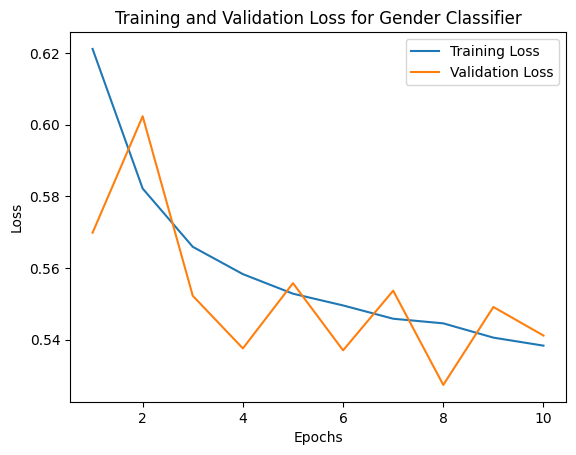

In [ ]:
# plotting validation and training loss
plt.plot(df['epoch'], df['loss'], label='Training Loss')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Gender Classifier')
plt.legend()
plt.show()

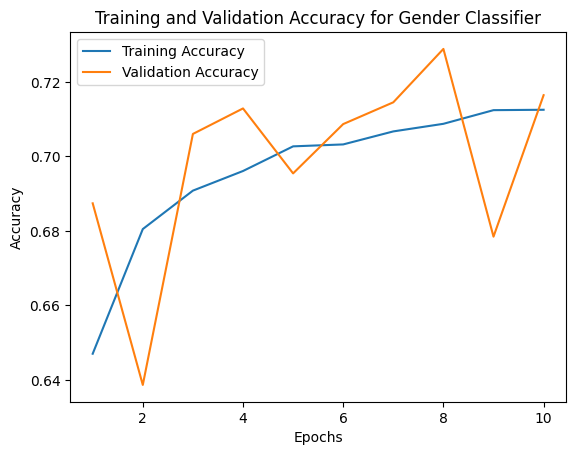

In [ ]:
# plotting validation and training accuracy
plt.plot(df['epoch'], df['acc'], label='Training Accuracy')
plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training and Validation Accuracy for Gender Classifier")
plt.legend()

### Confusion Matrix on Predictions

In [ ]:
gender_pred = gender_model.predict(scaled_val_img)
val_gender = np.array(val_gender)
matrix = confusion_matrix(y_true=val_gender.argmax(axis=1), y_pred=gender_pred.argmax(axis=1))

343/343 [==============================] - 1s 3ms/step


In [ ]:
matrix

array([[5117,  675],
       [2431, 2731]])

In [ ]:
Accuracy = (matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[0][1] + matrix[1][0] + matrix[1][1])
print("Accuracy: ", Accuracy)

Accuracy:  0.7164506116487128


#### Accuracy
The accuracy of the model is 71.7%, which is the percentage of correct predictions made by the model.

#### Confusion Matrix
The confusion matrix presented here is a table that indicates the performance of a gender prediction model on a validation set of face images. The model is tasked with predicting the gender of each face image, and 'Male' is labeled as 0 while 'Female' is labeled as 1.

The matrix indicates that the model correctly predicted 5117 male images and 2731 female images, representing the true positives for each class. However, the model misclassified 675 male images as female and 2431 female images as male, which are the false positives for females and males, respectively.

From this matrix, we can see that the model has a higher accuracy in predicting males than in predicting females.

## Classifying Age

In [ ]:
lr = 0.001
opt = keras.optimizers.Adam(learning_rate=lr)
bs = 32
epochs = 50

In [ ]:
age_model = get_model(9)
age_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
train_history = age_model.fit(scaled_train_img, np.array(train_age),
                    batch_size=bs, epochs=epochs,
                    verbose=1, shuffle=True, validation_data=(scaled_val_img, np.array(val_age)))
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

Epoch 1/50
2711/2711 [==============================] - 493s 182ms/step - loss: 1.7841 - accuracy: 0.3070 - val_loss: 1.7399 - val_accuracy: 0.3329
Epoch 2/50
2711/2711 [==============================] - 20s 7ms/step - loss: 1.7188 - accuracy: 0.3301 - val_loss: 1.6997 - val_accuracy: 0.3381
Epoch 3/50
2711/2711 [==============================] - 20s 7ms/step - loss: 1.7015 - accuracy: 0.3378 - val_loss: 1.7179 - val_accuracy: 0.3286
Epoch 4/50
2711/2711 [==============================] - 19s 7ms/step - loss: 1.6927 - accuracy: 0.3404 - val_loss: 1.6683 - val_accuracy: 0.3543
Epoch 5/50
2711/2711 [==============================] - 19s 7ms/step - loss: 1.6863 - accuracy: 0.3397 - val_loss: 1.6635 - val_accuracy: 0.3596
Epoch 6/50
2711/2711 [==============================] - 19s 7ms/step - loss: 1.6771 - accuracy: 0.3432 - val_loss: 1.6551 - val_accuracy: 0.3546
Epoch 7/50
2711/2711 [==============================] - 19s 7ms/step - loss: 1.6671 - accuracy: 0.3475 - val_loss: 1.6555 - val

#### Model Architecture

In [ ]:
age_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 100)               51300     
                                                                 
 dense_7 (Dense)             (None, 9)                 909       
                                                                 
Total params: 1,626,609
Trainable params: 1,626,609
Non-trainable params: 0
_________________________________________________________________


### Validation and Training Loss and Accuracy

In [ ]:
# creating a data frame for the loss and accuracy
df = pd.DataFrame({'epoch': np.arange(1,epochs+1), 'loss': loss, 'val_loss': val_loss, 'acc': acc, 'val_acc': val_acc})

In [ ]:
df

,epoch,loss,val_loss,acc,val_acc
0,1,1.784089,1.739939,0.306961,0.332938
1,2,1.718761,1.699723,0.330098,0.338141
2,3,1.701464,1.717879,0.337752,0.328647
3,4,1.692725,1.668296,0.340392,0.354300
4,5,1.686306,1.663491,0.339747,0.359595
5,6,1.677106,1.655090,0.343228,0.354574
6,7,1.667095,1.655548,0.347517,0.361329
7,8,1.661780,1.645443,0.348439,0.369728
8,9,1.655452,1.681100,0.351690,0.349827
9,10,1.652693,1.666366,0.350226,0.356399


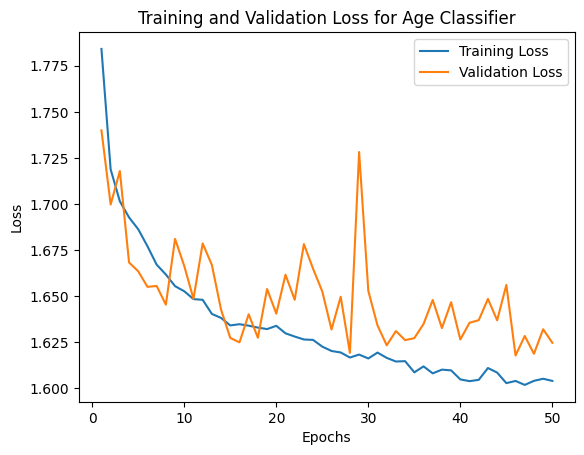

In [ ]:
# plotting validation and training loss
plt.plot(df['epoch'], df['loss'], label='Training Loss')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Age Classifier')
plt.legend()
plt.show()

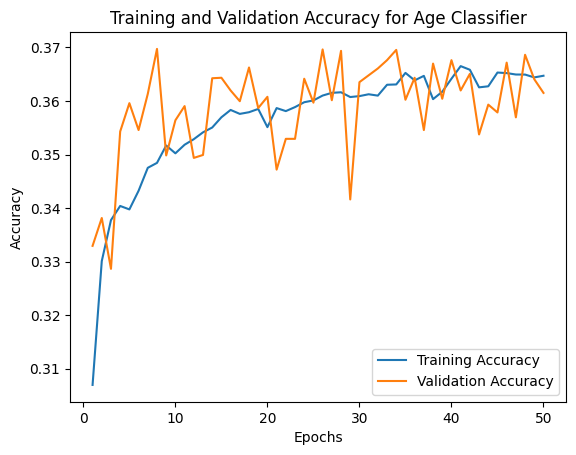

In [ ]:
# plotting validation and training accuracy
plt.plot(df['epoch'], df['acc'], label='Training Accuracy')
plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training and Validation Accuracy for Age Classifier")
plt.legend()

### Confusion Matrix on Predictions

In [ ]:
age_pred = age_model.predict(scaled_val_img)
val_age = np.array(val_age)
matrix = confusion_matrix(y_true=val_age.argmax(axis=1), y_pred=age_pred.argmax(axis=1))

343/343 [==============================] - 1s 3ms/step


In [ ]:
matrix

array([[   0,  139,    0,   44,   12,    0,    4,    0,    0],
       [   0,  679,   13,  572,   80,    0,   12,    0,    0],
       [   0,  149,   11,  878,  130,    0,   13,    0,    0],
       [   0,  115,    5, 2512,  601,    3,   64,    0,    0],
       [   0,   51,    3, 1543,  635,   10,   88,    0,    0],
       [   0,   34,    2,  723,  485,    7,  102,    0,    0],
       [   0,   15,    0,  305,  355,    5,  116,    0,    0],
       [   0,    2,    0,  105,  130,    2,   82,    0,    0],
       [   0,    2,    0,   36,   49,    1,   30,    0,    0]])

In [ ]:
Accuracy = (matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[0][1] + matrix[1][0] + matrix[1][1])
print("Accuracy: ", Accuracy)

Accuracy:  0.8300733496332519


#### Accuracy
The accuracy of the model is 83%, which is the percentage of correct predictions made by the model. However, the accuracy is not balanced between different classes as it can be observed from the confusion matrix.

#### Confusion Matrix
This confusion matrix represents the performance of a model that predicts the age range of people from face images. The model is trained to predict ages in 9 categories, ranging from '0-2' to 'more than 70'. The matrix shows the number of true positives, false positives, false negatives, and true negatives for each age category.

From this matrix, we can see that the model has a higher accuracy in predicting middle age groups than young babies or old adults.

# Task 2: Small Convolutional Neural Network

1. Build a convolutional neural network with the following specifications (Test on two different tasks):
- Convolution layer having 40 feature detectors, with kernel size 5 x 5, and ReLU as the activation function, with stride 1 and no-padding.
- A max-pooling layer with pool size 2x2.
- Fully connected layer with 100 neurons, and ReLU as the activation function.
- Output layer: n (depending on the task) neurons representing the n classes, using the softmax activation function. function for each of the 10 neurons.

2. Using Min-Max scaling to scale the training dataset and using the same Min and Max values from the training set scale the test dataset $$\frac{X-X_{min}}{X_{max}-X_{min}}.$$

3. Using mini-batch gradient descent to optimize the loss function: “categorical cross- entropy” on the training dataset. Please record the loss value for each of the epochs and create an epoch-loss plot and an accuracy-loss plot for both the training and validation set.

4. Report the following:
- Final classification accuracy.
- The n-class confusion matrix.



In [ ]:
# Define model for task 2
def get_model_2(output_dim):
    model = Sequential()
    model.add(Conv2D(filters=40, kernel_size=5, strides=(1, 1), padding="valid", input_shape=(32,32,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    return model

## Classfying Gender

In [ ]:
lr = 0.001
opt = keras.optimizers.Adam(learning_rate=lr)
bs = 32
epochs = 50

In [ ]:
scaled_train_img = [img.reshape(32,32,1) for img in scaled_train_img]
scaled_val_img = [img.reshape(32,32,1) for img in scaled_val_img]

#### Model Architecture

In [ ]:
gender_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 40)        1040      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 40)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 7840)              0         
                                                                 
 dense_10 (Dense)            (None, 100)               784100    
                                                                 
 dense_11 (Dense)            (None, 2)                 202       
                                                                 
Total params: 785,342
Trainable params: 785,342
Non-trainable params: 0
________________________________________________

## Training

In [ ]:
# create and compile the gender model
gender_model = get_model_2(2)
gender_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# train the model and record training history
train_history = gender_model.fit(x=np.array(scaled_train_img), y=np.array(train_gender),
                                 batch_size=bs, epochs=epochs,
                                 verbose=1, shuffle=True,
                                 validation_data=(np.array(scaled_val_img), np.array(val_gender)))
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']


# make gender predictions on the validation set and compute confusion matrix
gender_pred = gender_model.predict(np.array(scaled_val_img))
val_gender = np.array(val_gender)
matrix = confusion_matrix(y_true=val_gender.argmax(axis=1), y_pred=gender_pred.argmax(axis=1))



Epoch 1/50
2711/2711 [==============================] - 20s 7ms/step - loss: 0.5310 - accuracy: 0.7245 - val_loss: 0.4691 - val_accuracy: 0.7710
Epoch 2/50
2711/2711 [==============================] - 19s 7ms/step - loss: 0.4519 - accuracy: 0.7759 - val_loss: 0.4420 - val_accuracy: 0.7870
Epoch 3/50
2711/2711 [==============================] - 19s 7ms/step - loss: 0.4172 - accuracy: 0.7980 - val_loss: 0.4344 - val_accuracy: 0.7893
Epoch 4/50
2711/2711 [==============================] - 19s 7ms/step - loss: 0.3899 - accuracy: 0.8134 - val_loss: 0.4205 - val_accuracy: 0.7948
Epoch 5/50
2711/2711 [==============================] - 20s 7ms/step - loss: 0.3669 - accuracy: 0.8283 - val_loss: 0.4118 - val_accuracy: 0.8016
Epoch 6/50
2711/2711 [==============================] - 20s 7ms/step - loss: 0.3414 - accuracy: 0.8420 - val_loss: 0.4289 - val_accuracy: 0.7946
Epoch 7/50
2711/2711 [==============================] - 20s 7ms/step - loss: 0.3170 - accuracy: 0.8553 - val_loss: 0.4394 - val_ac

### Validation and Training Loss and Accuracy

In [ ]:
# creating a data frame for the loss and accuracy
df_task2 = pd.DataFrame({'epoch': np.arange(1,epochs+1), 'loss': loss, 'val_loss': val_loss, 'acc': acc, 'val_acc': val_acc})
df_task2

,epoch,loss,val_loss,acc,val_acc
0,1,0.530987,0.469073,0.724523,0.771043
1,2,0.451874,0.442004,0.775938,0.787018
2,3,0.417215,0.434399,0.798026,0.789301
3,4,0.389947,0.420510,0.813440,0.794778
4,5,0.366860,0.411779,0.828288,0.801625
5,6,0.341443,0.428858,0.841983,0.794596
6,7,0.317029,0.439398,0.855252,0.802720
7,8,0.291306,0.461719,0.869340,0.796513
8,9,0.266103,0.474214,0.882378,0.792131
9,10,0.239709,0.511446,0.895336,0.795326


### Accuracy Metrics

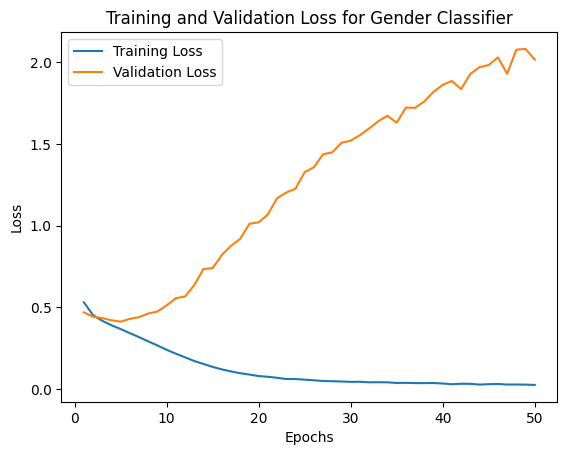

In [ ]:
# plotting validation and training loss
plt.plot(df_task2['epoch'], df_task2['loss'], label='Training Loss')
plt.plot(df_task2['epoch'], df_task2['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Gender Classifier')
plt.legend()
plt.show()

In [ ]:
# Output the results for gender classification
print(matrix)
print("Accuracy: ", (matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[0][1] + matrix[1][0] + matrix[1][1]))
print("Precision: ", matrix[0][0] / (matrix[0][0] + matrix[0][1]))

[[4536 1256]
 [1130 4032]]
Accuracy:  0.7821800255614387
Precision:  0.7831491712707183


#### Accuracy
The accuracy of the model is 78.21%, which is the percentage of correct predictions made by the model. 

#### Precision
The precision of the model is 78.31%, a metric that measures the accuracy of positive predictions.

#### Confusion Matrix
This confusion matrix represents the performance of a model that predicts people's gender from face images.
From the output, we can see that this model performs better when it predicts the male gender.

## Classfying Age

In [ ]:
# create and compile the age model
age_model = get_model_2(9)
age_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model and record training history
train_history = age_model.fit(np.array(scaled_train_img), np.array(train_age),
                    batch_size=bs, epochs=epochs,
                    verbose=1, shuffle=True, 
                    validation_data=(np.array(scaled_val_img), np.array(val_age)))
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

# make age predictions on the validation set and compute confusion matrix
age_pred = age_model.predict(np.array(scaled_val_img))
val_age = np.array(val_age)
matrix = confusion_matrix(y_true=val_age.argmax(axis=1), y_pred=age_pred.argmax(axis=1))

Epoch 1/50
2711/2711 [==============================] - 23s 9ms/step - loss: 1.6514 - accuracy: 0.3551 - val_loss: 1.5616 - val_accuracy: 0.3949
Epoch 2/50
2711/2711 [==============================] - 24s 9ms/step - loss: 1.5108 - accuracy: 0.3991 - val_loss: 1.4834 - val_accuracy: 0.4056
Epoch 3/50
2711/2711 [==============================] - 25s 9ms/step - loss: 1.4430 - accuracy: 0.4191 - val_loss: 1.4623 - val_accuracy: 0.4183
Epoch 4/50
2711/2711 [==============================] - 25s 9ms/step - loss: 1.3969 - accuracy: 0.4340 - val_loss: 1.4789 - val_accuracy: 0.4062
Epoch 5/50
2711/2711 [==============================] - 26s 9ms/step - loss: 1.3607 - accuracy: 0.4459 - val_loss: 1.4234 - val_accuracy: 0.4248
Epoch 6/50
2711/2711 [==============================] - 26s 10ms/step - loss: 1.3274 - accuracy: 0.4564 - val_loss: 1.4338 - val_accuracy: 0.4218
Epoch 7/50
2711/2711 [==============================] - 27s 10ms/step - loss: 1.2957 - accuracy: 0.4670 - val_loss: 1.4425 - val_

#### Model Architecture

In [ ]:
age_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 40)        1040      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 40)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 7840)              0         
                                                                 
 dense_14 (Dense)            (None, 100)               784100    
                                                                 
 dense_15 (Dense)            (None, 9)                 909       
                                                                 
Total params: 786,049
Trainable params: 786,049
Non-trainable params: 0
________________________________________________

### Validation and Training Loss and Accuracy

In [ ]:
# creating a data frame for the loss and accuracy
df_task2_age = pd.DataFrame({'epoch': np.arange(1,epochs+1), 'loss': loss, 'val_loss': val_loss, 'acc': acc, 'val_acc': val_acc})
df_task2_age

,epoch,loss,val_loss,acc,val_acc
0,1,1.651408,1.561587,0.355114,0.394924
1,2,1.510754,1.483411,0.399082,0.405605
2,3,1.443007,1.462286,0.419084,0.418295
3,4,1.396935,1.478939,0.433955,0.406153
4,5,1.360695,1.423431,0.445910,0.424776
5,6,1.327412,1.433758,0.456354,0.421764
6,7,1.295669,1.442516,0.467006,0.425963
7,8,1.264960,1.431561,0.478615,0.421490
8,9,1.235524,1.429776,0.491008,0.426146
9,10,1.205697,1.462324,0.501775,0.413091


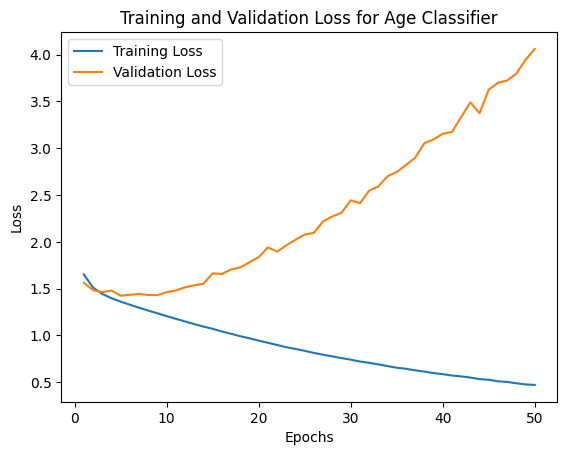

In [ ]:
# plotting validation and training loss
plt.plot(df_task2_age['epoch'], df_task2_age['loss'], label='Training Loss')
plt.plot(df_task2_age['epoch'], df_task2_age['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Age Classifier')
plt.legend()
plt.show()

In [ ]:
# Output the results for age classification
print(matrix)
print("Accuracy: ", (matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[0][1] + matrix[1][0] + matrix[1][1]))
print("Precision: ", matrix[0][0] / (matrix[0][0] + matrix[0][1]))

[[  99   77    5   11    4    1    1    0    1]
 [  57  792  218  142   79   46   14    7    1]
 [   6  195  299  402  182   56   24   12    5]
 [  11  152  376 1574  826  256   69   29    7]
 [   7   79  146  850  798  291  112   39    8]
 [   2   37   68  302  438  299  156   45    6]
 [   0   25   31  112  185  199  153   72   19]
 [   1    9    9   40   42   71   80   58   11]
 [   0    5    1   14   13   15   23   33   14]]
Accuracy:  0.8692682926829268
Precision:  0.5625


#### Accuracy
The accuracy of the model is 86.92%, which is the percentage of correct predictions made by the model. 

#### Precision
The precision of the model is 56.25%, a metric that measures the accuracy of positive predictions.

#### Confusion Matrix
This confusion matrix represents the performance of a model that predicts people's age from face images.
From the output, we can see that this model performs better when it predicts the elder people.

# Task 3: Your own Convolutional Neural Network

1. Build another convolutional neural network, where you choose all the parameters to see if you can get a higher accuracy.

2. Using Min-Max scaling to scale the training dataset and using the same Min and Max values from the training set scale the test dataset.

$$x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

3. Using mini-batch gradient descent to optimize the loss function: “categorical cross-entropy” on the training dataset. Please record the loss value for each of the epochs and create an epoch-loss plot and an accuracy-loss plot for both the training and validation set.

4. Report the following:
    - Final classification accuracy.
    - $n$-class confusion matrix.




## Model Architecture
1. Three Conv2D layers:
    - First layer: 32 filters, kernel size 3x3, stride 1x1, padding 'same', and ReLU activation.
    - Second layer: 64 filters, kernel size 3x3, stride 1x1, padding 'same', and ReLU activation.
    - Third layer: 128 filters, kernel size 3x3, stride 1x1, padding 'same', and ReLU activation.
2. BatchNormalization layers after each Conv2D layer for improved convergence and training stability.
3. MaxPooling2D layers after each Conv2D layer with pool size 2x2 and padding 'valid'.
4. Flatten layer to convert the 3D feature maps into a 1D vector.
5. Three Dense (fully connected) layers:
    - First Dense layer: 256 neurons with ReLU activation.
    - Second Dense layer: 128 neurons with ReLU activation.
    - Third Dense layer: 'output_dim' neurons with Softmax activation for classification.
6. Dropout layers after the first and second Dense layers with a dropout rate of 0.5 to reduce overfitting.

In [81]:
# modelling gender classification
def get_model_3(output_dim):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding="same", input_shape=(32, 32, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
    model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
    model.add(Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim, activation='softmax'))
    return model


## Gender Classification

In [82]:
# classifying gender
gender_model = get_model_3(2)

In [83]:
gender_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                      

In [84]:
scaled_train_img = [img.reshape(32,32,1) for img in scaled_train_img]
scaled_val_img = [img.reshape(32,32,1) for img in scaled_val_img]

In [88]:
lr = 0.001
opt = keras.optimizers.Adam(learning_rate=lr)
bs = 32
epochs = 10

In [89]:
gender_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
train_history = gender_model.fit(np.array(scaled_train_img), np.array(train_gender),
                    batch_size=bs, epochs=epochs,
                    verbose=1, shuffle=True, validation_data=(np.array(scaled_val_img), np.array(val_gender)))
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

Epoch 1/10
2711/2711 [==============================] - 87s 32ms/step - loss: 0.3910 - accuracy: 0.8194 - val_loss: 0.4081 - val_accuracy: 0.8031
Epoch 2/10
2711/2711 [==============================] - 99s 36ms/step - loss: 0.3740 - accuracy: 0.8294 - val_loss: 0.4034 - val_accuracy: 0.8120
Epoch 3/10
2711/2711 [==============================] - 96s 35ms/step - loss: 0.3551 - accuracy: 0.8378 - val_loss: 0.4084 - val_accuracy: 0.8042
Epoch 4/10
2711/2711 [==============================] - 91s 34ms/step - loss: 0.3382 - accuracy: 0.8460 - val_loss: 0.3960 - val_accuracy: 0.8029
Epoch 5/10
2711/2711 [==============================] - 93s 34ms/step - loss: 0.3211 - accuracy: 0.8568 - val_loss: 0.3838 - val_accuracy: 0.8167
Epoch 6/10
2711/2711 [==============================] - 99s 36ms/step - loss: 0.3058 - accuracy: 0.8643 - val_loss: 0.3919 - val_accuracy: 0.8150
Epoch 7/10
2711/2711 [==============================] - 94s 35ms/step - loss: 0.2880 - accuracy: 0.8711 - val_loss: 0.3773 -

### Validation and Training Loss and Accuracy

In [90]:
# creating a data frame for the loss and accuracy
df = pd.DataFrame({'epoch': np.arange(1,epochs+1), 'loss': loss, 'val_loss': val_loss, 'acc': acc, 'val_acc': val_acc})

In [91]:
df

,epoch,loss,val_loss,acc,val_acc
0,1,0.391001,0.408089,0.819365,0.803086
1,2,0.373978,0.403391,0.829441,0.812032
2,3,0.355143,0.408370,0.837833,0.804181
3,4,0.338193,0.396032,0.846007,0.802903
4,5,0.321145,0.383835,0.856751,0.816688
5,6,0.305822,0.391905,0.864290,0.814953
6,7,0.288019,0.377308,0.871150,0.822074
7,8,0.272013,0.401121,0.880764,0.807741
8,9,0.258644,0.409973,0.885099,0.810663
9,10,0.247393,0.416738,0.892073,0.812397


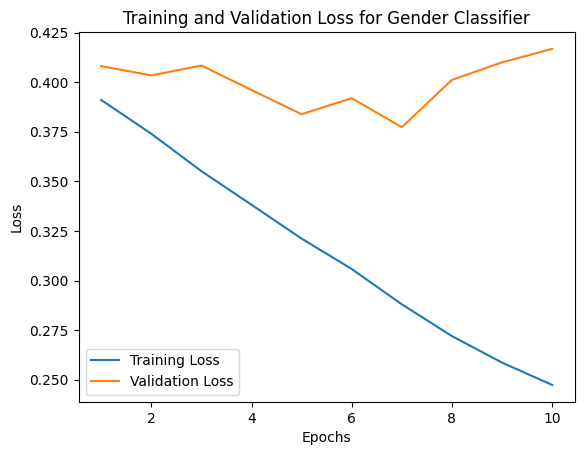

In [92]:
# plotting validation and training loss
plt.plot(df['epoch'], df['loss'], label='Training Loss')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Gender Classifier')
plt.legend()
plt.show()

## Confusion Matrix

In [93]:
# Concatenate images into a single tensor
val_img_tensor = np.concatenate([np.expand_dims(img, axis=0) for img in scaled_val_img], axis=0)

# Make a prediction
gender_pred = gender_model.predict(val_img_tensor)

val_gender = np.array(val_gender)
matrix = confusion_matrix(y_true=val_gender.argmax(axis=1), y_pred=gender_pred.argmax(axis=1))
matrix

343/343 [==============================] - 4s 11ms/step


array([[4509, 1283],
       [ 772, 4390]])

In [94]:
Accuracy = (matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[0][1] + matrix[1][0] + matrix[1][1])
print("Accuracy: ", Accuracy)

Accuracy:  0.8123972977907614


#### Discussion
We see that the model has an accuracy  of 81.23%. The model is better at classifying than the models in previous tasks. However, the model is still not balanced between different classes as it can be observed from the confusion matrix.

## Age Classification

In [95]:
#min-max scaling
flattened_train_img = [img.reshape(32*32) for img in train_img]
flattened_val_img = [img.reshape(32*32) for img in val_img]

scaler = MinMaxScaler()
scaler.fit(flattened_train_img)
print(len(scaler.data_max_), len(scaler.data_min_))# 255 and 0, len=1024

scaled_train_img = scaler.transform(flattened_train_img)
scaled_val_img = scaler.transform(flattened_val_img)

scaled_train_img = [img.reshape(32,32,1) for img in scaled_train_img]
scaled_val_img = [img.reshape(32,32,1) for img in scaled_val_img]

1024 1024


In [96]:
# classifying age group
age_model = get_model_3(9)

In [97]:
age_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_10 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                      

In [98]:
lr = 0.001
opt = keras.optimizers.Adam(learning_rate=lr)
bs = 32
epochs = 10

In [99]:
from keras.utils import to_categorical

# # Convert labels to one-hot encoding
# train_age_onehot = to_categorical(train_age, num_classes=9)
# val_age_onehot = to_categorical(val_age, num_classes=9)

# Compile the model
age_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

train_history = age_model.fit(np.array(scaled_train_img), np.array(train_age),
                    batch_size=bs, epochs=epochs,
                    verbose=1, shuffle=True, validation_data=(np.array(scaled_val_img), np.array(val_age)))
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

Epoch 1/10
2711/2711 [==============================] - 96s 35ms/step - loss: 1.8723 - accuracy: 0.2915 - val_loss: 1.7393 - val_accuracy: 0.3551
Epoch 2/10
2711/2711 [==============================] - 97s 36ms/step - loss: 1.7308 - accuracy: 0.3265 - val_loss: 1.6360 - val_accuracy: 0.3686
Epoch 3/10
2711/2711 [==============================] - 91s 33ms/step - loss: 1.6522 - accuracy: 0.3497 - val_loss: 1.5976 - val_accuracy: 0.3701
Epoch 4/10
2711/2711 [==============================] - 94s 35ms/step - loss: 1.5930 - accuracy: 0.3679 - val_loss: 1.6240 - val_accuracy: 0.3767
Epoch 5/10
2711/2711 [==============================] - 93s 34ms/step - loss: 1.5391 - accuracy: 0.3848 - val_loss: 1.5108 - val_accuracy: 0.3992
Epoch 6/10
2711/2711 [==============================] - 97s 36ms/step - loss: 1.4861 - accuracy: 0.4005 - val_loss: 1.4968 - val_accuracy: 0.3927
Epoch 7/10
2711/2711 [==============================] - 100s 37ms/step - loss: 1.4461 - accuracy: 0.4127 - val_loss: 1.4645 

### Validation and Training Loss and Accuracy

In [100]:
# creating a data frame for the loss and accuracy
df = pd.DataFrame({'epoch': np.arange(1,epochs+1), 'loss': loss, 'val_loss': val_loss, 'acc': acc, 'val_acc': val_acc})

In [101]:
df

,epoch,loss,val_loss,acc,val_acc
0,1,1.872339,1.739347,0.291478,0.355121
1,2,1.730788,1.636005,0.326489,0.368632
2,3,1.652238,1.597590,0.349742,0.370093
3,4,1.592968,1.623966,0.367853,0.376666
4,5,1.539133,1.510781,0.384764,0.399215
5,6,1.486146,1.496791,0.400500,0.392733
6,7,1.446140,1.464491,0.412743,0.409166
7,8,1.414507,1.448412,0.421724,0.409622
8,9,1.385394,1.445195,0.431719,0.403414
9,10,1.362223,1.455695,0.439362,0.405697


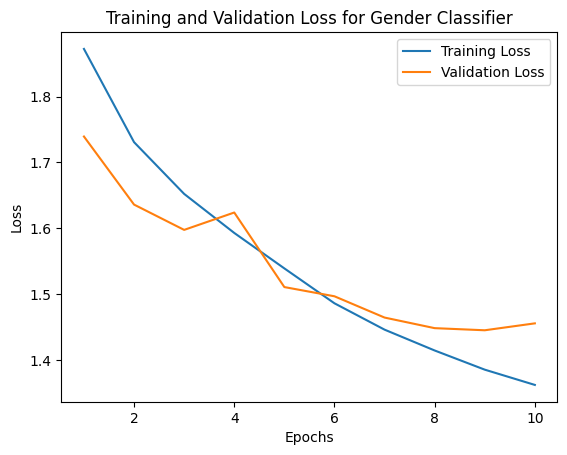

In [102]:
# plotting validation and training loss
plt.plot(df['epoch'], df['loss'], label='Training Loss')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Gender Classifier')
plt.legend()
plt.show()

In [103]:
# Concatenate images into a single tensor
val_img_tensor = np.concatenate([np.expand_dims(img, axis=0) for img in scaled_val_img], axis=0)

# Make a prediction
age_pred = age_model.predict(val_img_tensor)

val_age = np.array(val_age)
matrix = confusion_matrix(y_true=val_age.argmax(axis=1), y_pred=age_pred.argmax(axis=1))

343/343 [==============================] - 4s 11ms/step


In [104]:
matrix

array([[   4,  171,    0,   19,    3,    1,    1,    0,    0],
       [   0,  810,    5,  506,   32,    3,    0,    0,    0],
       [   0,  152,   13,  906,  100,   10,    0,    0,    0],
       [   0,   36,    7, 2392,  837,   25,    3,    0,    0],
       [   0,   12,    0, 1239,  979,   93,    7,    0,    0],
       [   0,    4,    0,  427,  727,  167,   28,    0,    0],
       [   0,    1,    0,  157,  352,  208,   78,    0,    0],
       [   0,    2,    0,   41,  104,  100,   73,    1,    0],
       [   0,    1,    0,    9,   39,   27,   40,    2,    0]])

In [105]:
Accuracy = (matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[0][1] + matrix[1][0] + matrix[1][1])
print("Accuracy: ", Accuracy)

Accuracy:  0.8263959390862944


### Discussion
The model has an accuracy of 82.6%. The model is better at classifying than the models in previous tasks. However, the model is still not balanced between different classes as it can be observed from the confusion matrix. Like the previous models, it is better at predicting middle age groups than young babies or old adults.

# Task 4:  Your own Convolutional Neural Network on both Tasks Simultaneously


1. Build another convolutional neural network, where you try and classify both tasks with a single network. After your flatten layer have two more fully connected layers for each “branch”. Note that in order to do so you will not be able to use the Sequential model.

2. Using Min-Max scaling to scale the training dataset and using the same Min and Max values from the training set scale the test dataset $$x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$$.

3. Using mini-batch gradient descent to optimize the loss function: “categorical cross-entropy” on the training dataset. Please record the loss value for each of the epochs and create an epoch-loss plot and an accuracy-loss plot for both the training and validation set.

4. Report the following:
    - Final classification accuracy.
    - $n$-class confusion matrix.


In [106]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten

In [107]:
# Define output dimensions for each attribute
output_dim = {'gender': 2, 'age': 9, 'race': 7}

In [108]:
# Define function to get label arrays for attributes
def get_labels(attr_list):
    train_labels, val_labels = [], []
    for attr in attr_list:
        if attr == 'gender':
            train_labels.append(np.array(train_gender))
            val_labels.append(np.array(val_gender))
        elif attr == 'age':
            train_labels.append(np.array(train_age))
            val_labels.append(np.array(val_age))
        elif attr == 'race':
            train_labels.append(np.array(train_race))
            val_labels.append(np.array(val_race))
        else:
            raise ValueError(f"Invalid attribute: {attr}")
    return train_labels, val_labels

In [109]:
# Define function to create model
def get_model_4():
    # Define input layer
    input_layer = Input(shape=(32, 32, 1))

    # Define convolutional and pooling layers
    x = Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding="valid", activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
    x = Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
    x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

    # Define output layers for each attribute
    x = Flatten()(x)
    output_layers = []
    for attr in attr_list:
        output = Dense(128, activation='relu')(x)
        output = Dense(64, activation='relu')(output)
        output = Dense(output_dim[attr], activation='softmax', name=attr)(output)
        output_layers.append(output)

    # Define model with input and output layers
    model = Model(inputs=input_layer, outputs=output_layers)
    
    return model

In [110]:
# Set attributes as a list
attr_list = ['gender', 'age']

# Get attribute labels for training and validation sets
train_labels, val_labels = get_labels(attr_list)

# Create model
model = get_model_4()

In [111]:
model.summary()

# Compile model with loss and optimizer
model.compile(loss=['categorical_crossentropy'] * len(attr_list),
                optimizer='adam', metrics='accuracy')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 30, 30, 16)   160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 15, 15, 16)  0           ['conv2d_16[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_17 (Conv2D)             (None, 13, 13, 32)   4640        ['max_pooling2d_16[0][0]']   

In [112]:
bs = 32
epochs = 10

In [113]:
# Train model
history = model.fit(np.array(scaled_train_img), train_labels,
                    validation_data=(np.array(scaled_val_img), val_labels),
                    batch_size=bs,
                    epochs=epochs,
                    verbose=True,
                    shuffle=True)

Epoch 1/10
2711/2711 [==============================] - 23s 8ms/step - loss: 2.2749 - gender_loss: 0.5749 - age_loss: 1.6999 - gender_accuracy: 0.6826 - age_accuracy: 0.3405 - val_loss: 2.0928 - val_gender_loss: 0.5159 - val_age_loss: 1.5769 - val_gender_accuracy: 0.7332 - val_age_accuracy: 0.3837
Epoch 2/10
2711/2711 [==============================] - 24s 9ms/step - loss: 2.0177 - gender_loss: 0.4825 - age_loss: 1.5352 - gender_accuracy: 0.7545 - age_accuracy: 0.3889 - val_loss: 1.9790 - val_gender_loss: 0.4724 - val_age_loss: 1.5066 - val_gender_accuracy: 0.7610 - val_age_accuracy: 0.4012
Epoch 3/10
2711/2711 [==============================] - 22s 8ms/step - loss: 1.9228 - gender_loss: 0.4506 - age_loss: 1.4722 - gender_accuracy: 0.7743 - age_accuracy: 0.4077 - val_loss: 1.9313 - val_gender_loss: 0.4667 - val_age_loss: 1.4646 - val_gender_accuracy: 0.7637 - val_age_accuracy: 0.4159
Epoch 4/10
2711/2711 [==============================] - 22s 8ms/step - loss: 1.8658 - gender_loss: 0.43

In [114]:
# Get training history metrics
total_train_loss = history.history['loss']
total_val_loss = history.history['val_loss']

attr_train_loss = {}
attr_train_acc = {}
attr_val_loss = {}
attr_val_acc = {}

for attr in attr_list:
    attr_train_loss[attr] = history.history[f"{attr}_loss"]
    attr_train_acc[attr] = history.history[f"{attr}_accuracy"]
    attr_val_loss[attr] = history.history[f"val_{attr}_loss"]
    attr_val_acc[attr] = history.history[f"val_{attr}_accuracy"]

# Print training history metrics
print("\nTotal training loss:", total_train_loss)
print("\nTotal validation loss:", total_val_loss)


Total training loss: [2.274850368499756, 2.0176801681518555, 1.9228259325027466, 1.8658283948898315, 1.8251802921295166, 1.7950416803359985, 1.7673461437225342, 1.7463908195495605, 1.7270270586013794, 1.7099673748016357]

Total validation loss: [2.0927507877349854, 1.9789972305297852, 1.9313405752182007, 1.8675098419189453, 1.8437237739562988, 1.8598159551620483, 1.832127571105957, 1.8508437871932983, 1.8493467569351196, 1.8430756330490112]


In [115]:
for attr in attr_list:
    print(f"Training loss for {attr}: {attr_train_loss[attr]}")
    print(f"Training accuracy for {attr}: {attr_train_acc[attr]}")
    print(f"Validation loss for {attr}: {attr_val_loss[attr]}")
    print(f"Validation accuracy for {attr}: {attr_val_acc[attr]}")

Training loss for gender: [0.5749205946922302, 0.4825230538845062, 0.45058807730674744, 0.4310881793498993, 0.41719427704811096, 0.405813992023468, 0.39540764689445496, 0.38678961992263794, 0.38086965680122375, 0.3740086257457733]
Training accuracy for gender: [0.6826408505439758, 0.7545190453529358, 0.7742552757263184, 0.7879507541656494, 0.7955132126808167, 0.8021996021270752, 0.8072373867034912, 0.8130590915679932, 0.8176473379135132, 0.8206331133842468]
Validation loss for gender: [0.5158711075782776, 0.47244375944137573, 0.4667123556137085, 0.4338483512401581, 0.4258001446723938, 0.424514502286911, 0.41786128282546997, 0.42111629247665405, 0.43884989619255066, 0.4162079691886902]
Validation accuracy for gender: [0.7331568598747253, 0.7610005736351013, 0.763739287853241, 0.7818148732185364, 0.7852839231491089, 0.7895745635032654, 0.7926784753799438, 0.7916742563247681, 0.7901223301887512, 0.7934088110923767]
Training loss for age: [1.6999318599700928, 1.535156011581421, 1.472236037

In [116]:
# Validation loss and accuracy for each attribute in a dataframe
# Create dataframe with loss and accuracy for each attribute
df = pd.DataFrame({
    'epoch': range(1, epochs+1),
    'total_loss': total_train_loss,
    'total_val_loss': total_val_loss,
})
for attr in attr_list:
    df[f"{attr}_loss"] = attr_train_loss[attr]
    df[f"val_{attr}_loss"] = attr_val_loss[attr]
    df[f"{attr}_acc"] = attr_train_acc[attr]
    df[f"val_{attr}_acc"] = attr_val_acc[attr]

df

,epoch,total_loss,total_val_loss,gender_loss,val_gender_loss,gender_acc,val_gender_acc,age_loss,val_age_loss,age_acc,val_age_acc
0,1,2.274850,2.092751,0.574921,0.515871,0.682641,0.733157,1.699932,1.576880,0.340531,0.383695
1,2,2.017680,1.978997,0.482523,0.472444,0.754519,0.761001,1.535156,1.506553,0.388868,0.401223
2,3,1.922826,1.931341,0.450588,0.466712,0.774255,0.763739,1.472236,1.464628,0.407694,0.415921
3,4,1.865828,1.867510,0.431088,0.433848,0.787951,0.781815,1.434740,1.433661,0.416801,0.420029
4,5,1.825180,1.843724,0.417194,0.425800,0.795513,0.785284,1.407985,1.417923,0.425355,0.431075
5,6,1.795042,1.859816,0.405814,0.424515,0.802200,0.789575,1.389228,1.435300,0.432572,0.420760
6,7,1.767346,1.832128,0.395408,0.417861,0.807237,0.792678,1.371940,1.414267,0.439846,0.425142
7,8,1.746391,1.850844,0.386790,0.421116,0.813059,0.791674,1.359597,1.429727,0.443374,0.419208
8,9,1.727027,1.849347,0.380870,0.438850,0.817647,0.790122,1.346156,1.410497,0.446797,0.431988
9,10,1.709967,1.843076,0.374009,0.416208,0.820633,0.793409,1.335957,1.426867,0.449714,0.412087


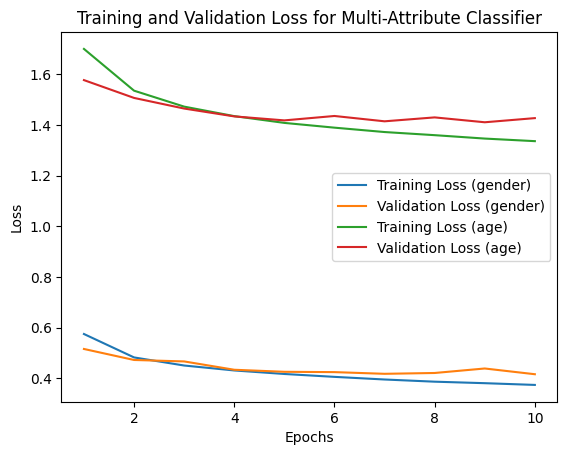

In [117]:
# Plot training and validation loss for each attribute
for attr in attr_list:
    plt.plot(df['epoch'], df[f"{attr}_loss"], label=f"Training Loss ({attr})")
    plt.plot(df['epoch'], df[f"val_{attr}_loss"], label=f"Validation Loss ({attr})")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Multi-Attribute Classifier')
plt.legend()
plt.show()

#### Discussions
It is clear from the results that making judgements about age is a lot harder than gender. Let's see the confusion matrix for both the tasks.

## Confusion Matrix and Accuracy

In [118]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize

# Get predicted labels for validation set
val_pred = model.predict(np.array(scaled_val_img))

# Get true labels for each attribute
true_labels = {}
for attr in attr_list:
    if attr == 'gender':
        true_labels[attr] = label_binarize(val_gender, classes=[0,1])
    elif attr == 'age':
        true_labels[attr] = label_binarize(val_age, classes=list(range(output_dim[attr])))
    elif attr == 'race':
        true_labels[attr] = label_binarize(val_race, classes=list(range(output_dim[attr])))

# Generate confusion matrix for each attribute and calculate accuracy
for i, attr in enumerate(attr_list):
    true = true_labels[attr]
    pred = np.argmax(val_pred[i], axis=1)
    labels = range(output_dim[attr])
    cm = confusion_matrix(true.argmax(axis=1), pred, labels=labels)
    accuracy = accuracy_score(true.argmax(axis=1), pred)
    print(f"Confusion matrix for {attr}:")
    print(cm)
    print(f"Accuracy for {attr}: {accuracy:.4f}\n")


343/343 [==============================] - 1s 4ms/step
Confusion matrix for gender:
[[4858  934]
 [1329 3833]]
Accuracy for gender: 0.7934

Confusion matrix for age:
[[ 130   56    1    6    5    1    0    0    0]
 [ 110  874  102  192   47   17    5    9    0]
 [   3  253  187  514  178   28    5   13    0]
 [   6  147  132 1746 1036  149   43   41    0]
 [   3   62   42  785 1043  281   64   49    1]
 [   3   40   25  262  523  291  129   78    2]
 [   0   19    3   93  211  191  135  142    2]
 [   0    3    2   38   44   72   55  104    3]
 [   0    3    0   11   15   13   17   55    4]]
Accuracy for age: 0.4121



### Comments

The accuracy for gender is higher than the accuracy for age. It ties up to the fact of what we saw before. Loss values are higher for training age than gender.

# Task 5: Variational Auto Encoder

1. Build a variational autoencoder with the following specifications (in this one you have a little more flexibility):
    - Should have at least two convolution layers in the encoder and 2 deconvolution layers in the decoder
    - Latent dimension should be at least 5.
    - Loss should be either MSE or binary cross entropy.

2. Using Min-Max scaling to scale the training dataset and using the same Min and Max values from the training set scale the test dataset $$x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$$.

3. Using mini-batch gradient descent to optimize the loss function on the training dataset. Please record the loss value for each of the epochs and create an epoch-loss plot and an accuracy-loss plot for both the training and validation set.

4. Qualitatively evaluate your model by generating a set of faces by randomly choosing 10 latent vectors and presenting the resulting images.




In [119]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import argparse
import os
import seaborn as sns
from tensorflow.keras.layers import Lambda, Input, Dense,Conv2DTranspose,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import matplotlib.gridspec as gridspec
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Lambda, Reshape, Conv2DTranspose

### Get Dataset

In [120]:
train_img, train_age, train_gender, train_race = get_dataset(DATA_DIR,'train')#, sample=True)
val_img, val_age, val_gender, val_race = get_dataset(DATA_DIR,'val')#, sample=True)

# min-max scaling
flattened_train_img = [img.reshape(32*32) for img in train_img]
flattened_val_img = [img.reshape(32*32) for img in val_img]

scaler = MinMaxScaler()
scaler.fit(flattened_train_img)
print(len(scaler.data_max_), len(scaler.data_min_))# 255 and 0, len=1024

scaled_train_img = scaler.transform(flattened_train_img)
scaled_val_img = scaler.transform(flattened_val_img)

scaled_train_img = np.array([img.reshape(32,32,1) for img in scaled_train_img])
scaled_val_img = np.array([img.reshape(32,32,1) for img in scaled_val_img])

1024 1024


In [121]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    #Extract mean and log of variance
    z_mean, z_log_var = args
    #get batch size and length of vector (size of latent space)
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]

    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    #Return sampled number (need to raise var to correct power)
    return z_mean + K.exp(z_log_var) * epsilon

## Encoder Model

In [122]:
latent_dim = 10

In [123]:
inputs = Input(shape=(32,32,1),name = 'encoder_input')
x = Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding="valid", activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = Conv2D(filters=32,kernel_size=3,strides=(1,1),padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = Conv2D(filters=64,kernel_size=3,strides=(1,1),padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [124]:
# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, z, name='encoder_output')
encoder.summary()

Model: "encoder_output"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_19 (Conv2D)             (None, 30, 30, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 max_pooling2d_19 (MaxPooling2D  (None, 15, 15, 16)  0           ['conv2d_19[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 13, 13, 32)   4640        ['max_pooling2d_19[0

# Decoder Model

In [1]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(7*7*512, activation='relu', name="decoder_hidden_layer")(latent_inputs)
x = Reshape((7,7,512))(x)
x = Conv2DTranspose(filters = 256, kernel_size = (4,4), strides = 2, padding = 'same',activation = 'relu')(x)
x = Conv2DTranspose(filters=128,kernel_size=(4,4),strides=2,padding='same', activation='relu')(x)
x = Conv2DTranspose(filters=64,kernel_size=(4,4),strides=2,padding='same', activation='relu')(x)
x = Conv2DTranspose(filters=32,kernel_size=(4,4),strides=2,padding='same', activation='relu')(x)
x = Conv2DTranspose(filters=3,kernel_size=(4,4),strides=2,padding='same', activation='sigmoid')(x)

NameError: name 'Input' is not defined

In [126]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs=x, name='decoder_output')
decoder.summary()

Model: "decoder_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 10)]              0         
                                                                 
 decoder_hidden_layer (Dense  (None, 128)              1408      
 )                                                               
                                                                 
 reshape (Reshape)           (None, 2, 2, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 64)         18496     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 9, 9, 32)         18464     
 ranspose)                                                       
                                                    

In [127]:
outputs = decoder(encoder(inputs))
vae = Model(inputs = inputs, outputs = outputs)
vae.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder_output (Functional)  (None, 10)               58772     
                                                                 
 decoder_output (Functional)  (None, 32, 32, 1)        45569     
                                                                 
Total params: 104,341
Trainable params: 104,341
Non-trainable params: 0
_________________________________________________________________


### Setting up the VAE Loss
We will need to set up the VAE model. We will use the encoder and decoder models we created above. We will also need to define the loss function and the optimizer. 
- Reconstruction loss: This is the loss between the original image and the reconstructed image. We will use the binary cross-entropy loss for this.

In [128]:
# setting loss
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= (32*32) #image_width*image_height

kl_loss = K.exp(z_log_var) + K.square(z_mean) - z_log_var - 1
print(kl_loss.shape)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= 0.05

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

(None, 10)


## Training

In [129]:
bs = 32
epochs = 10

In [130]:
train_history = vae.fit(scaled_train_img, scaled_train_img, batch_size=bs, epochs=epochs, verbose=1)


Epoch 1/10
2711/2711 [==============================] - 49s 18ms/step - loss: 21.4176
Epoch 2/10
2711/2711 [==============================] - 45s 17ms/step - loss: 14.6902
Epoch 3/10
2711/2711 [==============================] - 45s 17ms/step - loss: 14.2247
Epoch 4/10
2711/2711 [==============================] - 52s 19ms/step - loss: 14.0073
Epoch 5/10
2711/2711 [==============================] - 50s 18ms/step - loss: 13.8549
Epoch 6/10
2711/2711 [==============================] - 50s 18ms/step - loss: 13.7504
Epoch 7/10
2711/2711 [==============================] - 49s 18ms/step - loss: 13.6533
Epoch 8/10
2711/2711 [==============================] - 47s 17ms/step - loss: 13.5787
Epoch 9/10
2711/2711 [==============================] - 44s 16ms/step - loss: 13.5111
Epoch 10/10
2711/2711 [==============================] - 47s 17ms/step - loss: 13.4604


## Comparing the original and reconstructed images

1/1 [==============================] - 0s 19ms/step


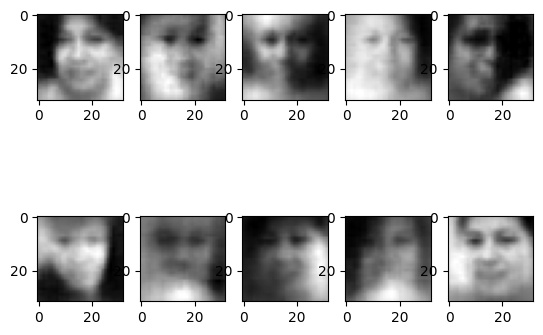

In [131]:
out_list = []
for i in range(10):
    plt.subplot(2,5,i+1)
    latent_vectors = np.random.randn(latent_dim).reshape(1, latent_dim)
    img = decoder.predict(latent_vectors)
    img = img.reshape(32,32)
    out_list.append(img)
    plt.imshow(img, cmap=plt.cm.gray)

plt.savefig('vae_output.png')

#### Discussion
The model reduces the face images to 10-dimensional latent vector. Then, reconstructs the images from the latent vector. The model is able to reconstruct the images as seen in the last output. However, the reconstructed images are not as good as the original images.